# Throughput Analysis

Fitting data to known distributions use is done using [Chi2Fit](https://hex.pm/packages/chi2fit).

This notebook describes the steps to do an analysis of throughput data. This supports the capability analysis of flow systems, like a kanban system.

This notebook is compatible with the section 'Understanding leadtime' from the [Kanban Maturity Model](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiIi9Py19zwAhW2DWMBHdKYDz0QFjALegQIHRAD&url=https%3A%2F%2Fmauvisoft.com%2Fkmm-understanding-lead-time%2F&usg=AOvVaw1iDIcri4tDi3vxo1W6yJp-)

## Table of contents

* [Data and simulation set-up](#Data-and-simulation-set-up)
* [Preparation](#Preparation)
* [Forecasting using a Poisson distribution](#Forecasting-using-a-Poisson-distribution)
* [Rate error propagation: Total Monte Carlo](#Rate-error-propagation:-Total-Monte-Carlo)
* [References](#References)

## Set-up

In [46]:
alias Chi2fit.Distribution, as: D
alias Chi2fit.Fit, as: F
alias Chi2fit.Matrix, as: M
alias Chi2fit.Utilities, as: U
alias Gnuplotlib, as: P
alias Exboost.Math

Exboost.Math

## Throughput data

First, decide on an interval for which to capture the throughput. Depending on the context and amount of data, daily, weekly, bi-weekly, or monthly intervals are common choices.

In [47]:
# Specify the interval in a number of days:
interval = 7

7

Next, choose the workitem to use for the throughput. For each interval count the number of work items completed in that interval. Partially completed items are excluded from the count.

In [48]:
# The raw throughput data:
raw = [1, 2, 0, 3, 0, 3, 1, 6, 0, 0, 1, 1, 0, 0, 1, 0, 3, 4, 5, 1, 7, 2, 3, 2, 1, 0, 1, 2, 0, 1, 0, 6, 5, 6, 0, 5, 0, 0, 2, 0, 0, 0, 1, 2, 15, 3, 1, 5, 2, 4, 0]

[1, 2, 0, 3, 0, 3, 1, 6, 0, 0, 1, 1, 0, 0, 1, 0, 3, 4, 5, 1, 7, 2, 3, 2, 1, 0, 1, 2, 0, 1, 0, 6, 5, 6, 0, 5, 0, 0, 2, 0, 0, 0, 1, 2, 15, 3, 1, 5, 2, 4, ...]

Because we don't count partially completed items some of the intervals will contain zero completed work items. If this gives unsatisfactory results later on, experiment by grouping intervals.

For example, when we start with weekly throughput data (interval = 7 days), we may group two consecutive intervals for get bi-weekly data. The properties of the data set that results from this grouping may be more realistic than the raw data.

Especially, if the lead time of work items is larger than the interval chosen, this may result in frequent zero throughput per interval. But, if in practice it never occurs that zero items are completed in two consecutive intervals, than grouping by two intervals may resemble the 'true' properties of the throughput better.

It is recommended to start with using the raw data and experiment with this in a later stage.

In [49]:
# The number of intervals to combine to form new (and larger) intervals:
groups = 1

1

Next, specify the grouping of the frequency of throughput data. These are called 'bins' and the size of the bins is called the bin size.

Usually, no grouping is good enough, i.e. a binsize of one. However, if a vast number of work items (tens or hundreds) are completed in the intervals the throughput may vary a lot. In this case it may help to use a bin size larger than 1. For example, bins of 0-4, 5-9, 10-14, etc.

Again, there is no recipe that tells what value to use. Start with one, and experiment to see what gives reliable results.

In [50]:
# The size of bins for grouping the frequency data
binsize = 1

1

### Basic properties of the data set

Next, we calculate some basic properties of the data set:

  * the size,
  * the average,
  * the median (middle value of the data set),
  * the tail (98%ile),
  * the mode (value that occurs the most).

In [51]:
# Modify the data based on the settings above:
data = raw |> Enum.chunk_every(groups,groups) |> Enum.map(& Enum.sum(&1))

# The size of the dataset
len = length(data)

# Maximum lead time in the data
maxdays = data |> Enum.max

# Het gemiddelde
avgdays = Enum.sum(data)/len

# Median & Tail (98%ile)
{median, tail, _} = data |> Enum.sort |> Enum.reduce({nil,nil,1}, fn
  lt, {nil,nil,idx} when (idx+1)/len > 0.50 -> {lt,nil,idx+1}
  lt, {me,nil,idx} when (idx+1)/len > 0.98 -> {me,lt,idx+1}
  _lt, {me,ta,idx} -> {me,ta,idx+1}
end)

# The mode is the value that occurs the most:
{mode,max_frequency} = data |> Enum.frequencies |> Enum.max_by(fn {_,v} -> v end)
:"do not show this result in output"

In [52]:
units = interval*groups
IO.puts "Mode          = #{round(mode)}"
IO.puts "Median        = #{median}"
IO.puts "Average       = #{Float.round(avgdays,1)}"
IO.puts "Tail (98%ile) = #{tail}"
IO.puts "\n(All amounts are per #{units} days)"
:"do not show this result in output"

Mode          = 0
Median        = 1
Average       = 2.1
Tail (98%ile) = 6

(All amounts are per 7 days)


## Visualisation of the data

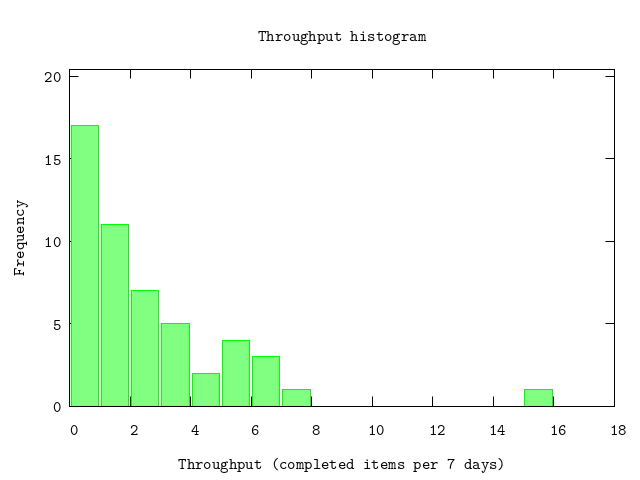

In [53]:
P.histogram(data,
    plottitle: "Throughput histogram",
    xlabel: "Throughput (completed items per #{units} days)",
    ylabel: "Frequency",
    xrange: '[0:#{maxdays*1.2}]',
    yrange: '[0:#{max_frequency*1.2}]',
    bin: binsize)
:"this is an inline image"

The chart may show a couple of things. Two important properties are (a) whether the data is multi modal or not and (b) whether it shows indications of a fat-tail.

Multi modal is recognized by more than 1 mode. Multi-modal data mostly is a result from the presence of multiple work item types. This will be analyzed below in more detail.

Fat-tailed data. This is also known as extremistan. Linear regression to the mean is not possible. The presence of data far to the right of the chart away from the mean, is a very strong indication that the data is extremistan.

### Thin- or fat-tailed data?

An important property of the data is to determine whether it is fat-tailed or not. With thin-tailed data forecasting is less uncertain, and is preferred.

A differentiator between mediocristan and extremistan data is to test the data sample for subexponentiality. Taleb [8] mentions 2 tests for this.

In [54]:
# Test 1:
# A value close to zero, say within 0.1, indicates it is extremistan (fat-tailed, subexponential)
test1 = data |> U.subexponential_stat(:max) < 0.1

true

In [55]:
# Test 2:
# A value close to zero, say within 0.1, indicates it is extremistan (fat-tailed, subexponential)
test2 = data |> U.subexponential_stat(:sum) < 0.1

true

In [56]:
# Thin or fat tailed distribution?
# See KMM.plus for an explanation of the numbers
check1 = tail/median < 5.6
check2 = if mode>0, do: tail/mode < 16, else: false

case {check1,check2} do
  {true,true} -> IO.puts "Data is thin tailed!"
  {false,false} -> IO.puts "Data is fat tailed!"
  _else -> IO.puts "Inclusive whether data is thin or fat tailed, check for multi-modal data (see below)"
end
:"do not show this result in output"

Data is fat tailed!


## Extremistan: finding a distribution

In the case of extremistan data we seek a probability distribution that is compatible with the observed data. The distributions with the highest values are good starting points.

In [57]:
data |> D.guess(2000) |> U.as_table({"Distribution","Likelihood"})
:"do not show this result in output"

Distribution|Likelihood          
------------|--------------------
poisson     |0.042754163632000915
nakagami    |0.05460907705409822 
erlang      |0.0659795744234219  
weibull     |0.06629521752068336 
exponential |0.06668864622994962 
wald        |0.07204366754823187 
frechet     |0.08552405570933133 
sep         |0.17699884893479348 
normal      |0.2955987013048619  


As a first step we convert the throughput data to a histogram. To this end we group the data in bins of size 1 starting at 0 and determine the cumulative distribution function (CDF). Since it is directly calculated from the observed data, we will call this the empirical cumulative distribution function (ECDF). This is the function that we will use to find a suitable probability distribution that describes the data.

An important property of a CDF (and therefor also for the ECDF) is that the value always is between 0 and 1.

In [58]:
hdata = U.to_bins data, {binsize,0}
hdata |> U.as_table({"bin index","value","low","high"})
:"do not show this result in output"

bin index|value             |low               |high               
---------|------------------|------------------|-------------------
1        |0.3333333333333333|0.2619590316047003|0.41205985002195966
2        |0.5490196078431373|0.4693334933381733|0.6265576074897032 
3        |0.6862745098039216|0.6081128777585465|0.7562025291870149 
4        |0.7843137254901961|0.7110378681422991|0.8448186366836251 
5        |0.8235294117647058|0.7533661771437564|0.8790002461835639 
6        |0.9019607843137255|0.8409447560847112|0.9439686602963081 
7        |0.9607843137254902|0.9111357425558969|0.9866556598542698 
8        |0.9803921568627451|0.9364212632226532|0.9973690503039632 
16       |1.0               |0.9641694112344984|1.0                


The data returned contains a list of tuples each describing a bin:
* the end-point of the bin,
* the proportional number of events for this bin (the total count is normalized to one),
* the lower value of the error bound,
* the upper value of the error bound.

As can be seen the sizes of the lower and upper bounds are different in value, i.e. they are asymmetrical. The contribution or weight to the likelihood function used in fitting known distributions will de different depending on whether the observed value if larger or smaller than the predicted value. This is specified by using the option `:linear` (see below). See [3] for details.

A consequence that the values of a CDF are between 0 and 1, is that the low and high bounds must be between 0 and 1. From this it follows that the error bounds are asymmetrical in nature. When finding a suitable distribution we need to take this into account.

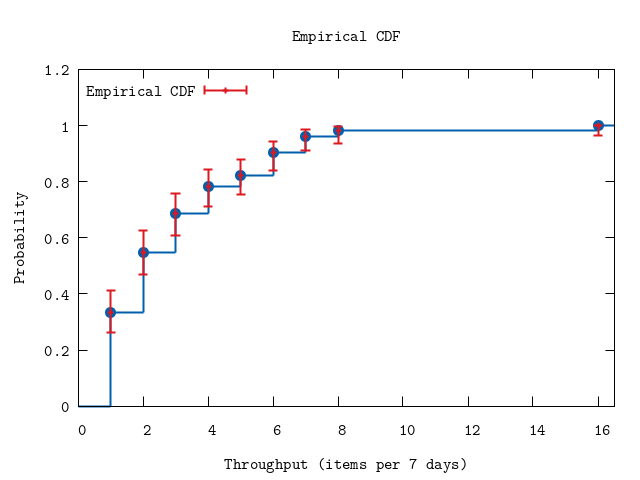

In [59]:
P.ecdf(hdata,
    plottitle: "Empirical CDF",
    xlabel: "Throughput (items per #{units} days)",
    ylabel: "Probability",
    xrange: '[0:#{maxdays*1.1}]',
    bin: binsize)
:"this is an inline image"

## Determining the distribution

As a preparation, we set some parameters that affect the algorithm for finding the parameter values of the distribution.

In [60]:
# Number of probes to use as an initial search.
# Values between 100 and 50_000 are reasonable numbers.
# For more extensive searches (costs more time) use values of 500_000 or 1_000_000
probes = 100_000

# Number of iterations to for fine-tuning the parameter values.
# Anything between 20 and 100 is reasonable. Start with 20.
iterations = 40
:"do not show this result in output"

Other parameters that affect the forecasting are listed below. Please adjust to your needs.

Instead of directly using the raw data captured one can also use a known probability distribution. The parameter of the distribution is matched to the data. After matching the parameter value one uses the known distribution to forecast.

Here, we will use the __Weibull distribution__ [1]. This basically assumes that the data points are independent of each other.

In [61]:
# The distribution to use
model = D.model "weibull"

# The number of parameters
Distribution.size(model)

2

In [62]:
# The range of the parameter values to look for a (global) minimum
# The number of tuples must match the number of parameters the distribution has (see above)
# This can be a rough estimate of the value (or random); the algorithm will try to find the precise value
initial = [{0.1,5.0},{1,avgdays*1.2}]

[{0.1, 5.0}, {1, 2.541176470588235}]

The code below uses basic settings of the commands provided by `Chi2Fit`. More advanced options can be found at [2]. First a fixed number of random parameter values are tried to get a rough estimate. The option `probes` equals the number of tries. Furthermore, since we are fitting a probability distribution which has values on the interval `[0,1]` the errors are asymmetrical. This is specified by the option `linear`. 

In [63]:
options = [probes: probes, smoothing: false, model: :linear, saved?: true]
result = {_,parameters,_,saved} = F.chi2probe hdata, initial, {Distribution.cdf(model), &F.nopenalties/2}, options
U.display result

Initial guess:
    chi2:		0.8556666509158083
    pars:		[1.0030811173573677, 2.537590186876523]
    ranges:		{[0.8747054712991019, 1.1126569938106348], [2.296021155252987, 2.5410289850337486]}



:ok

The errors reported is the found range of parameter values where the corresponding `chi2` values are within 1 of the found minimum value.

After roughly locating the minimum we do a more precise (and computationally more expensive) search for the minimum.

In [64]:
options = [{:probes,saved}|options]
result = {_,cov,parameters,_} = F.chi2fit hdata, {parameters, Distribution.cdf(model), &F.nopenalties/2}, iterations, options
U.display(hdata,model,result,options)

Final:
    chi2:		0.8390490486375306
    Degrees of freedom:	7
    gradient:		[5.8476874750018036e-8, 1.2562368208177508e-8]
    parameters:		[1.020450285470515, 2.569653855150381]
    errors:		[0.1496489418506129, 0.26916296388460237]
    ranges:
			chi2:		0.8390490486375306	-	1.8356657251085
			parameter:	0.8747054712991019	-	1.1126569938106348
			parameter:	2.2982143492267593	-	2.601893136002352


:ok

Some checks for a "good" fit:

  * gradient: for a (local) minimum the value of the gradient should be very close to zero,
  * chi-squared (`chi2`): should be 1 per degree of freedom.
  
A chi-squared value of 2 or larger per degree of freedom is an indication that the chosen distribution is not compatible with the data.


On the other hand, a chi-squared value much smaller than 1 is an indication that the distribution matches the data too easily. It describes the data very well, but will be bad at predicting and forecasting. This usually happens when (a) the distribution contains too many parameters, or (b) too little data points, i.e. large error bars.

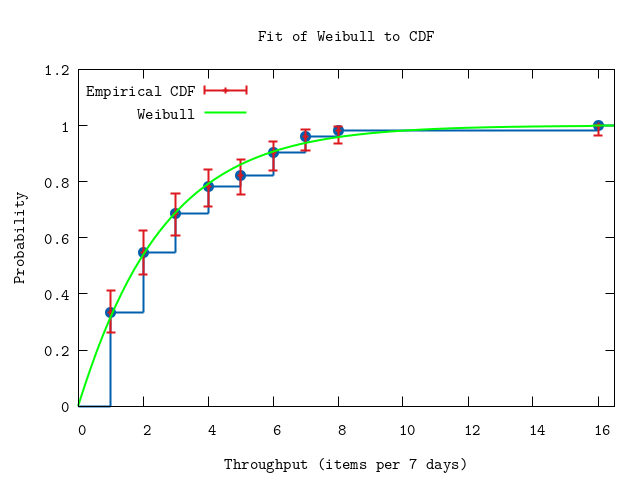

In [65]:
name = Distribution.name(model)|>String.capitalize()
P.ecdf(hdata,
    plottitle: "Fit of #{name} to CDF",
    xlabel: "Throughput (items per #{units} days)",
    ylabel: "Probability",
    xrange: '[0:#{maxdays*1.1}]',
    title: name,
    bin: binsize,
    func: & Distribution.cdf(model).(&1,parameters))
:"this is an inline image"

## Verifying the found distribution with the frequency charts

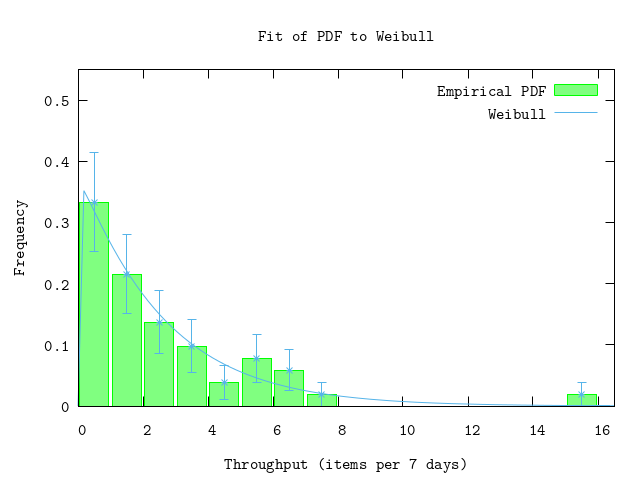

In [66]:
pdf = fn x -> Distribution.pdf(model).(x,parameters) end
P.pdf(data,
    plottitle: "Fit of PDF to #{name}",
    xlabel: "Throughput (items per #{units} days)",
    ylabel: "Frequency",
    xrange: '[0:#{maxdays*1.1}]',
    yrange: '[0:0.55]',
    bin: binsize,
    pdf: pdf,
    title: name)
:"this is an inline image"

## Forecasting

We will be interested in forecasting to answer two questions:

  1. How many items will we b e able to deliver within a certain period?
  1. Given a number of work items, when will these be done?
  

### Forecasting - duration

In [67]:
# The size of the backlog to use in estimations
todo = 100

# The number of iterations to use with Monte Carlo
mc_iterations = 10_000
:"do not show this result in output"

Using a Monte Carlo simulation we estimate the number of iterations and the range to expect.

In [68]:
{_avg,_sd,all} = U.mc(mc_iterations, U.forecast_duration(fn -> Distribution.random(model).(parameters) end, todo), collect_all?: true)
IO.puts "Estimation duration for #{todo} items (unit = #{units} days):\n"
U.display {all, :+}
:"do not show this result in output"

Estimation duration for 100 items (unit = 7 days):

50%    => 40 units
84%    => 47 units
97.5%  => 53 units
99.85% => 60 units


It shows that we have 84% chance to complete all items with 46 weeks, and a small chance of finishing them in 53 weeks.

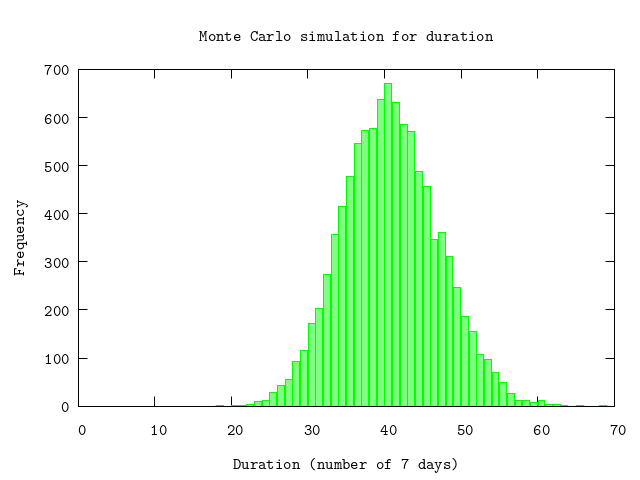

In [69]:
P.histogram(all,
    plottitle: "Monte Carlo simulation for duration",
    xlabel: "Duration (number of #{units} days)",
    ylabel: "Frequency",
    xrange: '[0:#{Enum.max(all)}]')
:"this is an inline image"

### Forecasting: number of work items

In [70]:
# The number of periods to for which to forecast the number of work items delivered
periods = 13
:"do not show this result in output"

Using a Monte Carlo simulation we estimate the number of iterations and the range to expect.

In [71]:
{avg,sd,all} = U.mc mc_iterations, U.forecast_items(fn -> round(Distribution.random(model).(parameters)) end,periods), collect_all?: true
U.display {all,:-}
:"do not show this result in output"

50%    => 32 units
84%    => 24 units
97.5%  => 17 units
99.85% => 12 units


This shows that we have a 84% chance of completing at least 24 work items in a period of 13. And a 97.5% chance of at least 18 item. This means that 18 work items are "guaranteed".

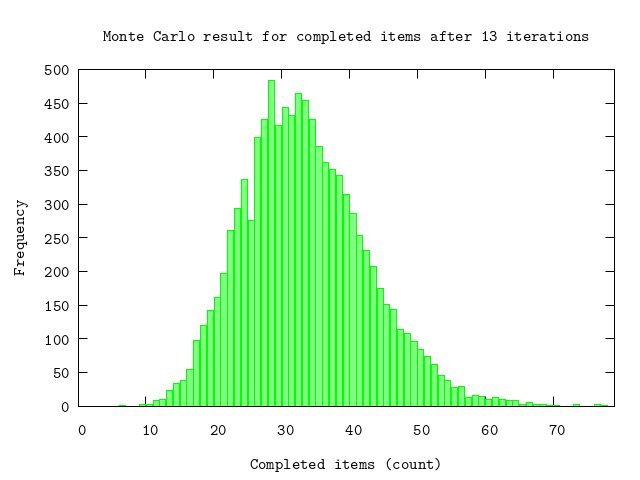

In [72]:
P.histogram(all,
    plottitle: "Monte Carlo result for completed items after #{periods} iterations",
    xlabel: "Completed items (count)",
    ylabel: "Frequency",
    xrange: '[0:#{Enum.max(all)}]')
:"this is an inline image"

## Appendix: error propagation - Total Monte Carlo

In the results of a Monte Carlo simulation the errors reported and the range of the number of iterations is the statistical error associated with the Monte Carlo simulation. It dopes not take into account the uncertainty of the parameter used in the fitted probability distribution function.

In Total Monte Carlo [4] multiple Monte Carlo simulations are done that correspond to the extreme values of the error bounds of the used parameters. The error results is of a different nature than the statistical error from the Monte Carlo simulation. These error reported separately.

In [73]:
# The number of iterations to use in the Monte Carlo method
# Less iterations is faster, but larger error. A larger value results in better results,
# but costs more processing time.
mc_iterations = 10_000

# Two options for mode of operation:
# 1. `:use_bounds' - uses the parameters value and covariance matrix,
# 2. `:use_ranges' - uses the ranges from the chi2-fit.
{valmin, valmax} = U.total_mc(result, &fn -> U.forecast(fn -> Distribution.random(model).(&1) end, todo) end, :use_bounds, mc_iterations)

sd_min = max(0.0, avg - valmin)
sd_plus = max(0.0, valmax - avg)

IO.puts "Number of iterations to complete the backlog:"
IO.puts "#{Float.round(avg,1)} (+/- #{Float.round(sd,1)}) (-#{Float.round(sd_min,1)} +#{Float.round(sd_plus,1)})"
:"do not show this result in output"

Number of iterations to complete the backlog:
33.0 (+/- 9.1) (-0.0 +13.8)


The first error is symmetric while the second error reported is asymmetric.

#### Combining the errors

We now have estimated two erros which have a different origin:

1. _statistical error_ caused by the nature of the Poisson distribution as determined in [Forecasting using a Poisson distribution](#Forecasting-using-a-Poisson-distribution), and
1. _systematic error_ caused by the error in the deliveray rate in [this section](#Rate-error-propagation:-Total-Monte-Carlo)

Making the assumption that both are Gaussian - which is true for the _systematic error_ but which is false for the _systematic error_ - allows us to combine the two by quadratically addition.

In [74]:
# Assuming both error typs are gaussian distributed (which probably is not true):
sd_avg = (sd_plus + sd_min)/2
total = :math.sqrt(sd*sd + sd_avg*sd_avg)
U.display {avg,total,:-}
:"do not show this result in output"

50%    => 33.0 units
84%    => 22.0 units
97.5%  => 11.0 units
99.85% => -1.0 units


## Appendix: Bimodal Poisson

In this section we will fit sample data thathas two modes, i.e. visually contains two bumps in the data.
Using a one of the 'standard' distributions to fir the data is dificult as this one distribution only has 1 mode.

Usually, this type of data contains a mix of two work item types: each work item type corresponding to one of the bumps. Two approaches exist to handle such data:

  1. use a bi-modal distribution to fit the complete data set,
  1. separate both work item types in the data and perform the analysis for both work items separately
  

We form a new distribution by combining two distributions. Each distribution (work item type) is given a certain weight `w1` and `w2`. The sum of the two weights is equal to 1.

In [81]:
# This ensures that the weights w_1 and w_2 will be positive and less than 1
# The penalty acts as a constraint for the fitting procedure
penalty = fn _,[w1|_] -> cond do
  w1 < 0 -> 1_000_000_000
  w1 > 1 -> 1_000_000_000
  true -> 0
  end
end
:"do not show this result in output"

We will combine two Poisson distributions each having a different delivery rate parameter to form a new bi-modal Poisson distribution.

Note that this introduces 2 additional parameters so that we have a total of 3 parameters. Unless you have many data points, introducing more parameters may result in a very small chi-squared statistic.

In [82]:
model2 = %Distribution.BiModal{distribs: [%Distribution.Poisson{},%Distribution.Poisson{}]}
initial = [{0,1},{0.1,10.0},{0.1,10.0}]
options = [probes: 50_000, smoothing: false, model: :linear, saved?: true]
result = {_,parameters2,_,saved} = F.chi2probe hdata, initial, {Distribution.cdf(model2), penalty}, options
U.display result

Initial guess:
    chi2:		0.36754988330519583
    pars:		[0.6700742402867552, 1.6420969716200688, 5.301489185216024]
    ranges:		{[0.1799304305846927, 0.8285977260101447], [0.8270646684954859, 6.900867375251137], [0.835672928996914, 6.686046769636131]}



:ok

After determining roughly the optimal values for the parameters we will fine-tune them by performaing a chi-squared fit:

In [83]:
options = [{:probes,saved}|options]
result = {_,cov,parameters2,_} = F.chi2fit hdata, {parameters2, Distribution.cdf(model2), penalty}, 20, options
U.display(hdata,model2,result,options)

Final:
    chi2:		0.30567511693144805
    Degrees of freedom:	6
    gradient:		[3.0489225337168027e-9, -3.5670089756772626e-8, 1.3275980909398123e-8]
    parameters:		[0.6370755618015221, 1.6153636471428205, 5.105899418232546]
    errors:		[0.24159498777110952, 0.7245234008011712, 1.399139368434782]
    ranges:
			chi2:		0.305675116931448	-	1.30342819408881
			parameter:	0.1799304305846927	-	0.8285977260101447
			parameter:	0.8270646684954859	-	6.900867375251137
			parameter:	0.9247856377802312	-	6.686046769636131


:ok

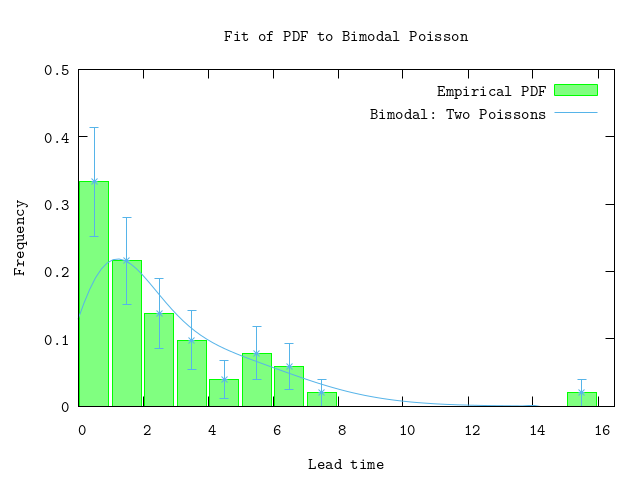

In [84]:
pdf2 = fn x -> Distribution.pdf(model2).(x,parameters2) end
P.pdf(data,
    plottitle: "Fit of PDF to Bimodal Poisson",
    xlabel: "Lead time",
    ylabel: "Frequency",
    xrange: '[0:#{maxdays*1.1}]',
    yrange: '[0:0.50]',
    pdf: pdf2,
    bin: binsize,
    title: "Bimodal: Two Poissons")
:"this is an inline image"

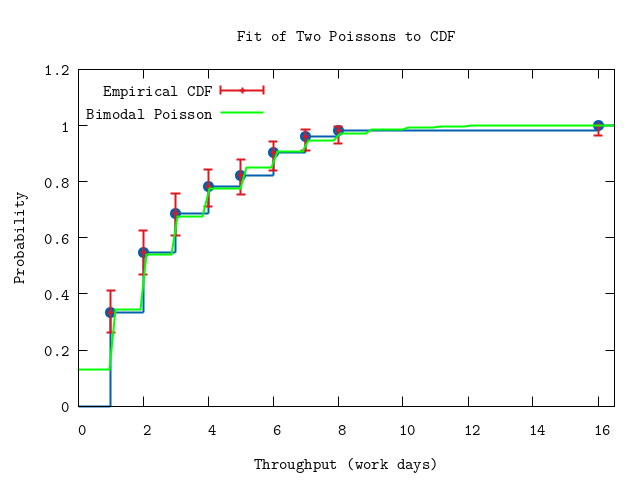

In [85]:
P.ecdf(hdata,
    plottitle: "Fit of Two Poissons to CDF",
    xlabel: "Throughput (work days)",
    ylabel: "Probability",
    xrange: '[0:#{maxdays*1.1}]',
    title: "Bimodal Poisson",
    func: & Distribution.cdf(model2).(&1,parameters2))
:"this is an inline image"

The figure below shows the two individual fitted Poisson distributions.

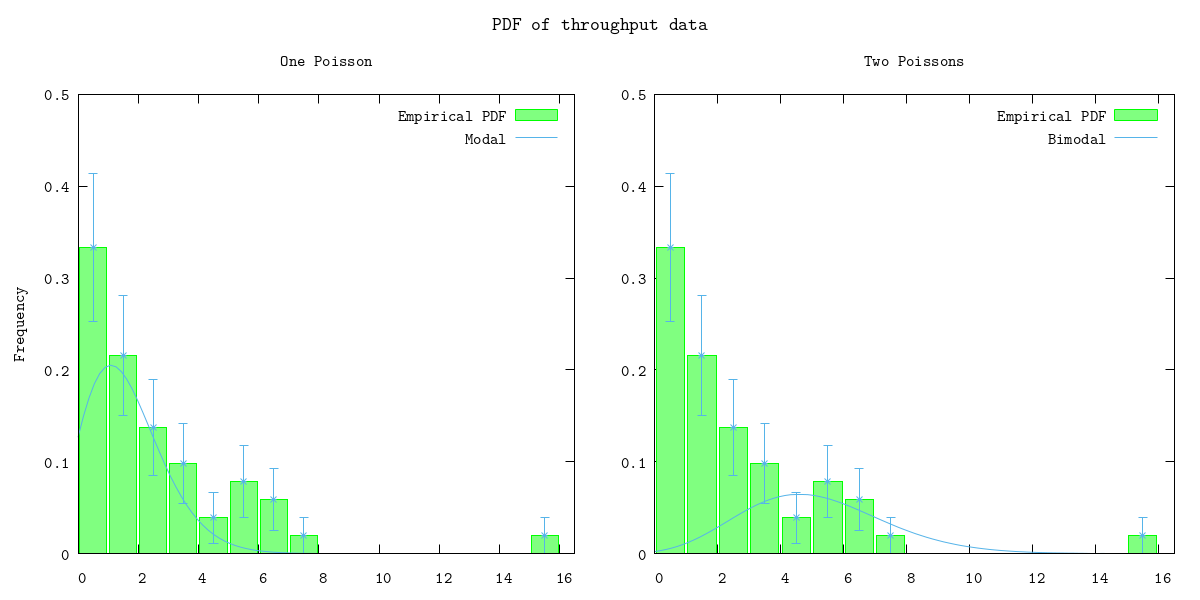

In [86]:
model = D.model "poisson"
pdf1 = fn x -> (parameters2|>hd)*Distribution.pdf(model).(x,parameters2|>Enum.slice(1,1)) end
pdf2 = fn x -> (1-(parameters2|>hd))*Distribution.pdf(model).(x,parameters2|>Enum.slice(2,1)) end
P.multi([
    P.pdf(data, plottitle: "One Poisson",ylabel: "Frequency",xrange: '[0:#{maxdays*1.1}]', yrange: '[0:0.5]',pdf: pdf1,title: "Modal",bin: binsize, mode: :as_commands),
    P.pdf(data, plottitle: "Two Poissons",xrange: '[0:#{maxdays*1.1}]',yrange: '[0:0.5]',pdf: pdf2,title: "Bimodal",bin: binsize, mode: :as_commands),
],columns: 2, title: "PDF of throughput data", size: "1200,600")
:"this is an inline image"

## References

[1] _Poisson distribution_, https://en.wikipedia.org/wiki/Poisson_distribution/<br>
[2] _Chi2Fit_, Pieter Rijken, 2018, https://hex.pm/packages/chi2fit<br>
[3] _Asymmetric errors_, Roger Barlow, Manchester University, UK and Stanford University, USA, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003, https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf<br>
[4] _Efficient use of Monte Carlo: uncertainty propagation_, D. Rochman et. al., Nuclear Science and Engineering, 2013, ftp://ftp.nrg.eu/pub/www/talys/bib_rochman/fastTMC.pdf<br>
[5] _Understanding lead time_, https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiIi9Py19zwAhW2DWMBHdKYDz0QFjALegQIHRAD&url=https%3A%2F%2Fmauvisoft.com%2Fkmm-understanding-lead-time%2F&usg=AOvVaw1iDIcri4tDi3vxo1W6yJp-<br>
[6] _Kanban Maturity Model_, .....<br>
[7] _KMM: A Map To Organizational Agility, Resilience & Reinvention_, http://kmm.plus<br>
[8] _Statistical consequences of fat tails_, Nassim Taleb